# LightGBM

We explore the solution of using LightGBM models using the `HistGradientBoostingRegressor` implementation from `scikit-learn`

In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.stats as stats
import string
import time
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from src.utils import *

In [2]:
# Datasets
BASELINE_TRAIN = "data/train/baseline_train.csv"
BASELINE_VAL = "data/train/baseline_val.csv"
BASELINE_TEST = "data/test/baseline_test.csv"

TRUNCATED_BASELINE_TRAIN = "data/train/baseline-truncated_train.csv"
TRUNCATED_BASELINE_VAL = "data/train/baseline-truncated_val.csv"
TRUNCATED_BASELINE_TEST = "data/test/baseline-truncated_test.csv"

BASELINE_W_FEAT_ENG_TRAIN = "data/train/baseline-w-feature-eng_train.csv"
BASELINE_W_FEAT_ENG_VAL = "data/train/baseline-w-feature-eng_val.csv"
BASELINE_W_FEAT_ENG_TEST = "data/test/baseline-w-feature-eng_test.csv"

TRUNCATED_FEAT_ENG_TRAIN = "data/train/truncated-feat-eng_train.csv"
TRUNCATED_FEAT_ENG_VAL = "data/train/truncated-feat-eng_val.csv"
TRUNCATED_FEAT_ENG_TEST = "data/test/truncated-feat-eng_test.csv"

In [3]:
def random_string(k: int = 6) -> str:
    res = "".join(random.choices(string.ascii_uppercase + string.digits, k=k))
    return str(res)

In [4]:
def save_lightgbm_model(model: HistGradientBoostingRegressor) -> str:
    ts = str(int(time.time()))
    res = random_string()
    filename = f"tmp/model/lightgbm_{ts}_{res}.joblib"
    joblib.dump(model, filename)
    return filename

def load_lightgbm_model(filename: str) -> HistGradientBoostingRegressor:
    return joblib.load(filename)

In [5]:
def save_test_prediction(y_pred) -> str:
    ts = str(int(time.time()))
    res = random_string()
    filename = f"tmp/pred/lightgbm_test_pred_{ts}_{res}.csv"
    y_pred = np.array(y_pred)
    pred_df = pd.DataFrame(y_pred, columns=["Predicted"])
    pred_df.index.name = "Id"
    pred_df.to_csv(filename)
    return filename

## 0. Extra observations

### a. Special property of `monthly_rent` label

In [6]:
def round_to_nearest_price(y, round_interval: float = 50.0):
    # function to round the label to the nearest price (default: nearest 50 sgd)
    return np.round(np.array(y) / round_interval) * round_interval

In [7]:
df = pd.read_csv(BASELINE_TRAIN)
_, y_original = split_features_and_monthly_rent_label(df)
y_round = round_to_nearest_price(y_original, round_interval=50.0)

In [8]:
np.array_equal(y_original, y_round)

True

As shown above, there is a special property of the `monthly_rent` label: People like to set price at round number (in this case, price are set only at every 50 sgd interval). We will make use of this to see if we can improve our prediction by rounding the predicted price to the nearest 50 sgd

### b. Baseline parameters vs hyper-parameter tuning

In [9]:
df_train = pd.read_csv(BASELINE_TRAIN)
df_val = pd.read_csv(BASELINE_VAL)

In [10]:
X_train, y_train = split_features_and_monthly_rent_label(df_train)
X_val, y_val = split_features_and_monthly_rent_label(df_val)

Baseline parameters

In [11]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [12]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 470.88315512738154, Score = 0.5681035956260614


In [13]:
y_val_pred = model.predict(X_val)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
score_val = model.score(X_val, y_val)
print(f"Validation: RMSE = {rmse_val}, Score = {score_val}")

Validation: RMSE = 475.41995821097805, Score = 0.5389511932735701


Hyper-parameter tuning

In [14]:
param_space = {
    "learning_rate": stats.loguniform(1e-2, 1e0),
    "max_iter": [100, 1000],
    "max_leaf_nodes": [None, 31],
    "min_samples_leaf": stats.randint(10, 40),
    "l2_regularization": [0, 0.1],
}

In [15]:
model = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(),
    param_distributions=param_space,
    n_iter=20,
)
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=HistGradientBoostingRegressor(), n_iter=20,
                   param_distributions={'l2_regularization': [0, 0.1],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000221BDB59790>,
                                        'max_iter': [100, 1000],
                                        'max_leaf_nodes': [None, 31],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000221BDB7BF90>})

In [16]:
model.best_params_

{'l2_regularization': 0.1,
 'learning_rate': 0.11245429751757643,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 39}

In [17]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 470.3544220587656, Score = 0.56907296436401


In [18]:
y_val_pred = model.predict(X_val)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
score_val = model.score(X_val, y_val)
print(f"Validation: RMSE = {rmse_val}, Score = {score_val}")

Validation: RMSE = 474.779683073143, Score = 0.540192198423398


As we can see from the results above, there is very minimal gain from hyper-parameter tuning. As such, we will prioritize prediction improvement from data engineering rather than hyper-parameter tuning

### c. Prediction vs true value graph

Using the results above, we can sketch the predicion vs true value graph. As this graph is quite similar for all datasets, we will only sketch it once in this section to check how it looks like

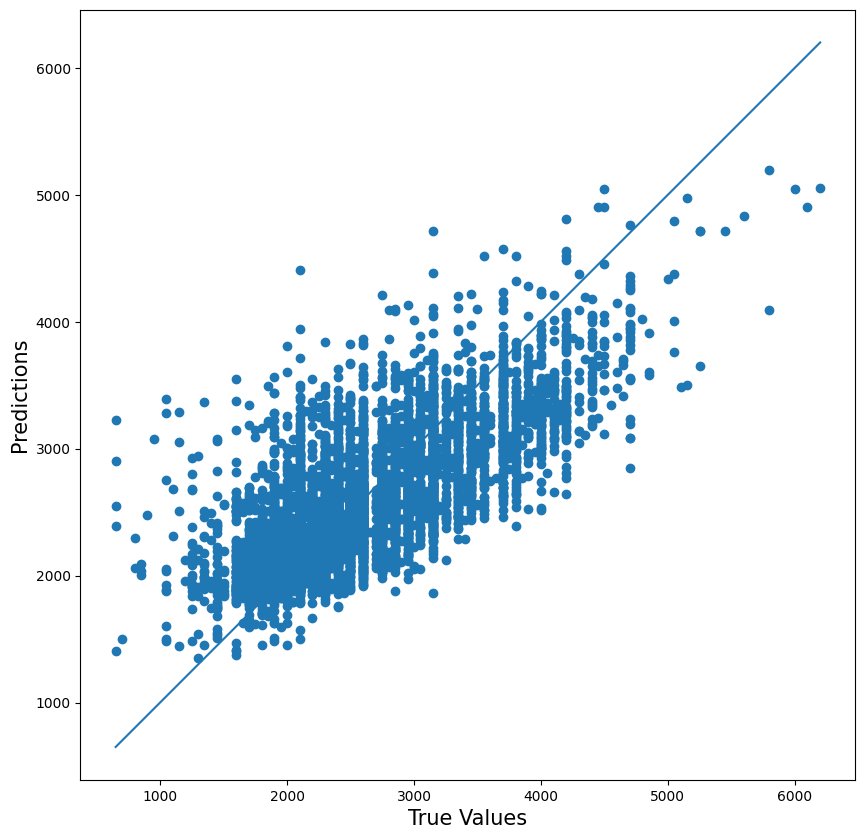

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(y_val, y_val_pred)
p1 = max(max(y_val_pred), max(y_val))
p2 = min(min(y_val_pred), min(y_val))
plt.plot([p1, p2], [p1, p2])
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.show()

## 1. Baseline (Cleaned dataset without feat eng variables)

In [20]:
train_path = BASELINE_TRAIN
val_path = BASELINE_VAL
test_path = BASELINE_TEST

In [21]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

### a. Prediction using the original `monthly_rent` label

In [22]:
X_train, y_train = split_features_and_monthly_rent_label(df_train)
X_val, y_val = split_features_and_monthly_rent_label(df_val)
X_test, _ = split_features_and_monthly_rent_label(df_test)

In [23]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698581373_4IR31Z.joblib


In [24]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 470.97488611920465, Score = 0.5679353069792842


In [25]:
y_val_pred = model.predict(X_val)
y_val_pred_round = round_to_nearest_price(y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
rmse_val_round = mean_squared_error(y_val, y_val_pred_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 475.7323632433293
Validation (rounded prediction): RMSE = 475.8111495120727


In [26]:
y_test_pred = model.predict(X_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698581373_MN5X7H.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698581373_HNDM4X.csv


### b. Prediction using custom `rent_per_sqm` label

In [27]:
X_train, y_train, floor_area_sqm_train = split_features_and_rent_per_sqm_label(df_train)
X_val, y_val, floor_area_sqm_val = split_features_and_rent_per_sqm_label(df_val)
X_test, _, floor_area_sqm_test = split_features_and_rent_per_sqm_label(df_test)

_, y_train_price = split_features_and_monthly_rent_label(df_train)
_, y_val_price = split_features_and_monthly_rent_label(df_val)

In [28]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698581379_RYD449.joblib


In [30]:
y_train_pred_ppsm = model.predict(X_train)
y_train_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_train_pred_ppsm, floor_area_sqm_train)
rmse_train = mean_squared_error(y_train_price, y_train_pred_price, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 484.2923654785169, Score = 0.6315263659884703


In [31]:
y_val_pred_ppsm = model.predict(X_val)
y_val_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_val_pred_ppsm, floor_area_sqm_val)
y_val_pred_price_round = round_to_nearest_price(y_val_pred_price)
rmse_val = mean_squared_error(y_val_price, y_val_pred_price, squared=False)
rmse_val_round = mean_squared_error(y_val_price, y_val_pred_price_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 486.8487322006596
Validation (rounded prediction): RMSE = 487.09855265644137


In [32]:
y_test_pred_ppsm = model.predict(X_test)
y_test_pred = convert_rent_per_sqm_label_to_monthly_rent_label(y_test_pred_ppsm, floor_area_sqm_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582490_AYSQJN.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582490_DKU1XL.csv


## 2. Dataset with additional features

In [33]:
train_path = BASELINE_W_FEAT_ENG_TRAIN
val_path = BASELINE_W_FEAT_ENG_VAL
test_path = BASELINE_W_FEAT_ENG_TEST

In [34]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

### a. Prediction using the original `monthly_rent` label

In [35]:
X_train, y_train = split_features_and_monthly_rent_label(df_train)
X_val, y_val = split_features_and_monthly_rent_label(df_val)
X_test, _ = split_features_and_monthly_rent_label(df_test)

In [36]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582496_PQ4NHK.joblib


In [37]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 471.1192991113379, Score = 0.5676703021010041


In [38]:
y_val_pred = model.predict(X_val)
y_val_pred_round = round_to_nearest_price(y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
rmse_val_round = mean_squared_error(y_val, y_val_pred_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 475.5102896026055
Validation (rounded prediction): RMSE = 475.42218080354644


In [39]:
y_test_pred = model.predict(X_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582497_7273N9.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582497_WUT8XQ.csv


### b. Prediction using custom `rent_per_sqm` label

In [40]:
X_train, y_train, floor_area_sqm_train = split_features_and_rent_per_sqm_label(df_train)
X_val, y_val, floor_area_sqm_val = split_features_and_rent_per_sqm_label(df_val)
X_test, _, floor_area_sqm_test = split_features_and_rent_per_sqm_label(df_test)

_, y_train_price = split_features_and_monthly_rent_label(df_train)
_, y_val_price = split_features_and_monthly_rent_label(df_val)

In [41]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582502_6KTNTU.joblib


In [42]:
y_train_pred_ppsm = model.predict(X_train)
y_train_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_train_pred_ppsm, floor_area_sqm_train)
rmse_train = mean_squared_error(y_train_price, y_train_pred_price, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 484.00954655517467, Score = 0.6329314321758092


In [43]:
y_val_pred_ppsm = model.predict(X_val)
y_val_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_val_pred_ppsm, floor_area_sqm_val)
y_val_pred_price_round = round_to_nearest_price(y_val_pred_price)
rmse_val = mean_squared_error(y_val_price, y_val_pred_price, squared=False)
rmse_val_round = mean_squared_error(y_val_price, y_val_pred_price_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 488.96019825307326
Validation (rounded prediction): RMSE = 489.31584891560584


In [44]:
y_test_pred_ppsm = model.predict(X_test)
y_test_pred = convert_rent_per_sqm_label_to_monthly_rent_label(y_test_pred_ppsm, floor_area_sqm_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582502_TYAN9C.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582502_97O6VO.csv


## 3. Truncated baseline dataset (extra columns removal)

In [45]:
train_path = TRUNCATED_BASELINE_TRAIN
val_path = TRUNCATED_BASELINE_VAL
test_path = TRUNCATED_BASELINE_TEST

In [46]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

### a. Prediction using the original `monthly_rent` label

In [47]:
X_train, y_train = split_features_and_monthly_rent_label(df_train)
X_val, y_val = split_features_and_monthly_rent_label(df_val)
X_test, _ = split_features_and_monthly_rent_label(df_test)

In [48]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582504_RYGOLV.joblib


In [49]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 473.118880464112, Score = 0.5639926223050177


In [50]:
y_val_pred = model.predict(X_val)
y_val_pred_round = round_to_nearest_price(y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
rmse_val_round = mean_squared_error(y_val, y_val_pred_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 476.43654808355495
Validation (rounded prediction): RMSE = 476.8149536245691


In [51]:
y_test_pred = model.predict(X_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582504_DDTQWJ.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582504_SBW0Y7.csv


### b. Prediction using custom `rent_per_sqm` label

In [52]:
X_train, y_train, floor_area_sqm_train = split_features_and_rent_per_sqm_label(df_train)
X_val, y_val, floor_area_sqm_val = split_features_and_rent_per_sqm_label(df_val)
X_test, _, floor_area_sqm_test = split_features_and_rent_per_sqm_label(df_test)

_, y_train_price = split_features_and_monthly_rent_label(df_train)
_, y_val_price = split_features_and_monthly_rent_label(df_val)

In [53]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582506_RLG44E.joblib


In [54]:
y_train_pred_ppsm = model.predict(X_train)
y_train_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_train_pred_ppsm, floor_area_sqm_train)
rmse_train = mean_squared_error(y_train_price, y_train_pred_price, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 485.1143261578816, Score = 0.6295893916039943


In [55]:
y_val_pred_ppsm = model.predict(X_val)
y_val_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_val_pred_ppsm, floor_area_sqm_val)
y_val_pred_price_round = round_to_nearest_price(y_val_pred_price)
rmse_val = mean_squared_error(y_val_price, y_val_pred_price, squared=False)
rmse_val_round = mean_squared_error(y_val_price, y_val_pred_price_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 487.65577486568037
Validation (rounded prediction): RMSE = 487.8810476608685


In [56]:
y_test_pred_ppsm = model.predict(X_test)
y_test_pred = convert_rent_per_sqm_label_to_monthly_rent_label(y_test_pred_ppsm, floor_area_sqm_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582506_AX0U80.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582506_W8H9BX.csv


## 4. Truncated baseline + additional features dataset

In [57]:
train_path = TRUNCATED_FEAT_ENG_TRAIN
val_path = TRUNCATED_FEAT_ENG_VAL
test_path = TRUNCATED_FEAT_ENG_TEST

In [58]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

### a. Prediction using the original `monthly_rent` label

In [59]:
X_train, y_train = split_features_and_monthly_rent_label(df_train)
X_val, y_val = split_features_and_monthly_rent_label(df_val)
X_test, _ = split_features_and_monthly_rent_label(df_test)

In [60]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582508_1535LE.joblib


In [61]:
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 470.0750001593485, Score = 0.569584811087428


In [62]:
y_val_pred = model.predict(X_val)
y_val_pred_round = round_to_nearest_price(y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
rmse_val_round = mean_squared_error(y_val, y_val_pred_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 475.88728534075983
Validation (rounded prediction): RMSE = 475.914470607202


In [63]:
y_test_pred = model.predict(X_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582508_XWAA81.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582508_PUM68S.csv


### b. Prediction using custom `rent_per_sqm` label

In [64]:
X_train, y_train, floor_area_sqm_train = split_features_and_rent_per_sqm_label(df_train)
X_val, y_val, floor_area_sqm_val = split_features_and_rent_per_sqm_label(df_val)
X_test, _, floor_area_sqm_test = split_features_and_rent_per_sqm_label(df_test)

_, y_train_price = split_features_and_monthly_rent_label(df_train)
_, y_val_price = split_features_and_monthly_rent_label(df_val)

In [65]:
model = HistGradientBoostingRegressor(
    learning_rate = 0.1,
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = None,
    min_samples_leaf = 20,
)
model.fit(X_train, y_train)
model_path = save_lightgbm_model(model)
print(f"Model saved at {model_path}")

Model saved at tmp/model/lightgbm_1698582509_WYGOF5.joblib


In [66]:
y_train_pred_ppsm = model.predict(X_train)
y_train_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_train_pred_ppsm, floor_area_sqm_train)
rmse_train = mean_squared_error(y_train_price, y_train_pred_price, squared=False)
score_train = model.score(X_train, y_train)
print(f"Training: RMSE = {rmse_train}, Score = {score_train}")

Training: RMSE = 484.8439874535361, Score = 0.6311742211286782


In [67]:
y_val_pred_ppsm = model.predict(X_val)
y_val_pred_price = convert_rent_per_sqm_label_to_monthly_rent_label(y_val_pred_ppsm, floor_area_sqm_val)
y_val_pred_price_round = round_to_nearest_price(y_val_pred_price)
rmse_val = mean_squared_error(y_val_price, y_val_pred_price, squared=False)
rmse_val_round = mean_squared_error(y_val_price, y_val_pred_price_round, squared=False)
print(f"Validation: RMSE = {rmse_val}")
print(f"Validation (rounded prediction): RMSE = {rmse_val_round}")

Validation: RMSE = 489.91840929828146
Validation (rounded prediction): RMSE = 490.0072278378487


In [68]:
y_test_pred_ppsm = model.predict(X_test)
y_test_pred = convert_rent_per_sqm_label_to_monthly_rent_label(y_test_pred_ppsm, floor_area_sqm_test)
y_test_pred_round = round_to_nearest_price(y_test_pred)
y_test_pred_path = save_test_prediction(y_test_pred)
y_test_pred_round_path = save_test_prediction(y_test_pred_round)
print(f"Test prediction saved at {y_test_pred_path}")
print(f"Test prediction (rounded prediction) saved at {y_test_pred_round_path}")

Test prediction saved at tmp/pred/lightgbm_test_pred_1698582510_VWD12P.csv
Test prediction (rounded prediction) saved at tmp/pred/lightgbm_test_pred_1698582510_DHWWOY.csv
